**Chapter 7 – Ensemble Learning and Random Forests**

_This notebook contains all the sample code and solutions to the exercises in chapter 7._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/07_ensemble_learning_and_random_forests.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

**Note**: to be future-proof, we set `solver="lbfgs"`, `n_estimators=100`, and `gamma="scale"` since these will be the default values in upcoming Scikit-Learn versions.

# AdaBoost

In [4]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

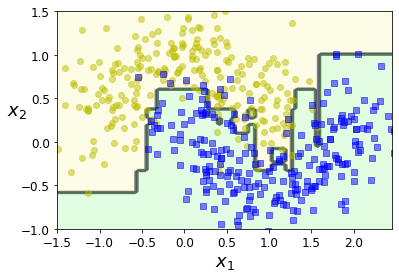

In [5]:
plot_decision_boundary(ada_clf, X, y)

Saving figure boosting_plot


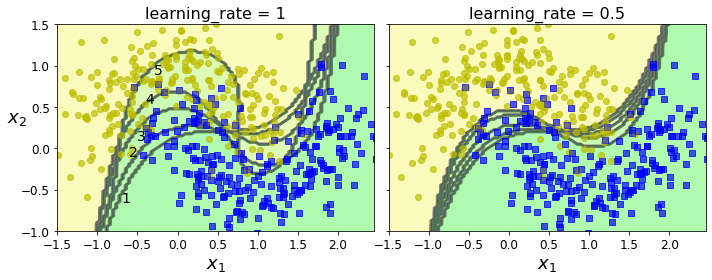

In [6]:
from sklearn.svm import SVC
m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m)
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="scale", random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()

In [7]:
list(m for m in dir(ada_clf) if not m.startswith("_") and m.endswith("_"))

['base_estimator_',
 'classes_',
 'estimator_errors_',
 'estimator_weights_',
 'estimators_',
 'feature_importances_',
 'n_classes_',
 'n_features_in_']

# Gradient Boosting

In [8]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [9]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [10]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [11]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [12]:
X_new = np.array([[0.8]])

In [13]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [14]:
y_pred

array([0.75026781])

In [15]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

Saving figure gradient_boosting_plot


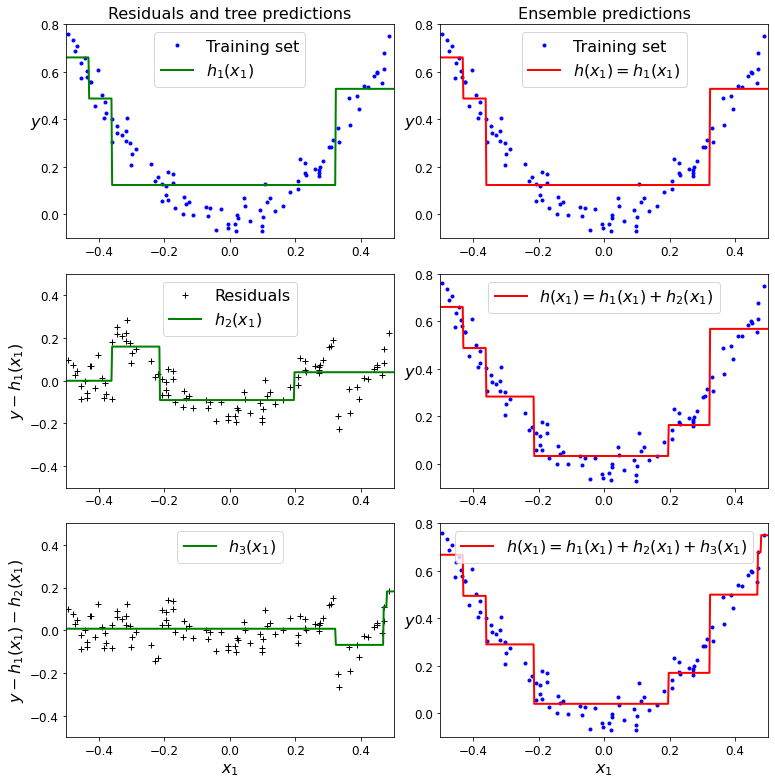

In [16]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

In [17]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [18]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

Saving figure gbrt_learning_rate_plot


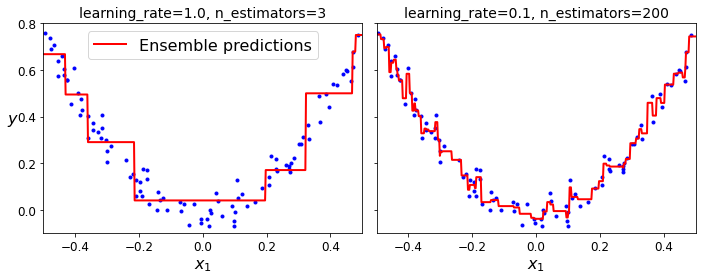

In [19]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

save_fig("gbrt_learning_rate_plot")
plt.show()

## Gradient Boosting with Early stopping

In [20]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

In [21]:
min_error = np.min(errors)

Saving figure early_stopping_gbrt_plot


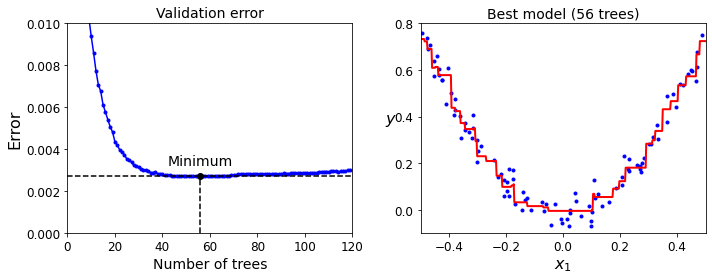

In [22]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("early_stopping_gbrt_plot")
plt.show()

In [23]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [24]:
print(gbrt.n_estimators)

61


In [25]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


## Using XGBoost

In [26]:
try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed.")
    xgboost = None

In [27]:
if xgboost is not None:  # not shown in the book
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fittrai(X_train, y_n)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred) # Not shown
    print("Validation MSE:", val_error)           # Not shown

Validation MSE: 0.004000408205406276


In [28]:
if xgboost is not None:  # not shown in the book
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], early_stopping_rounds=2)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)  # Not shown
    print("Validation MSE:", val_error)            # Not shown

[0]	validation_0-rmse:0.22834
[1]	validation_0-rmse:0.16224
[2]	validation_0-rmse:0.11843
[3]	validation_0-rmse:0.08760
[4]	validation_0-rmse:0.06848
[5]	validation_0-rmse:0.05709
[6]	validation_0-rmse:0.05297
[7]	validation_0-rmse:0.05129
[8]	validation_0-rmse:0.05155
[9]	validation_0-rmse:0.05211
Validation MSE: 0.002630868681577655


In [29]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None

24.5 ms ± 1.79 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [30]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

18.2 ms ± 631 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
